1

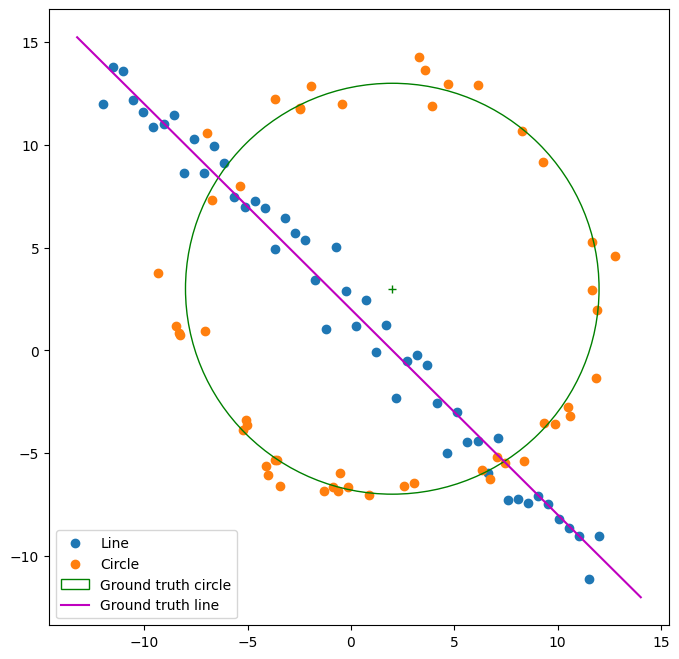

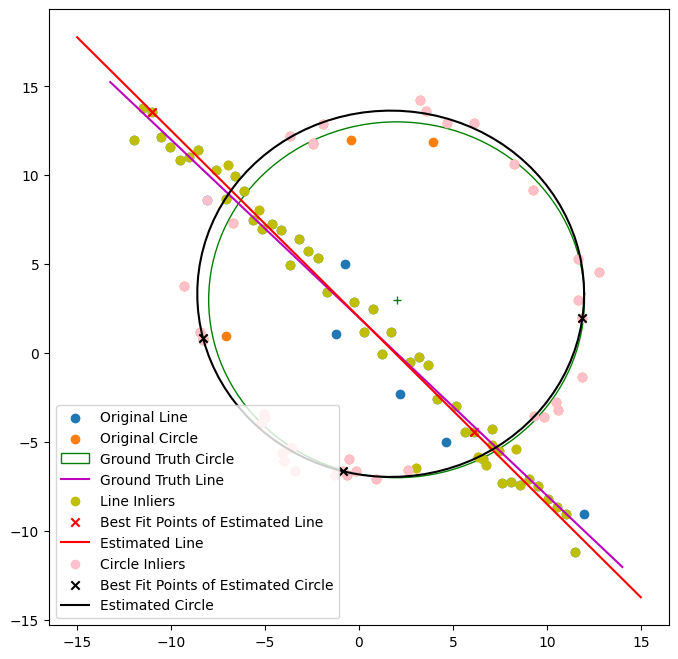

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Set random seed for reproducibility (optional)
# np.random.seed(0)

# Number of points and parameters
num_points = 100
half_num_points = num_points // 2
circle_radius = 10
circle_center_x, circle_center_y = 2, 3  # Center
circle_noise = circle_radius / 16
line_noise = 1.0
line_slope, line_intercept = -1, 2

# Generate points conforming to a circle
circle_angles = np.random.uniform(0, 2 * np.pi, half_num_points)
circle_noise_values = circle_noise * np.random.randn(half_num_points)
circle_x = circle_center_x + (circle_radius + circle_noise_values) * np.cos(circle_angles)
circle_y = circle_center_y + (circle_radius + circle_noise_values) * np.sin(circle_angles)
circle_points = np.hstack((circle_x.reshape(half_num_points, 1), circle_y.reshape(half_num_points, 1)))

# Generate points conforming to a line
line_x = np.linspace(-12, 12, half_num_points)
line_y = line_slope * line_x + line_intercept + line_noise * np.random.randn(half_num_points)
line_points = np.hstack((line_x.reshape(half_num_points, 1), line_y.reshape(half_num_points, 1)))

# Combine circle and line points into a single dataset
data_points = np.vstack((circle_points, line_points))

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(line_points[:, 0], line_points[:, 1], label='Line')
ax.scatter(circle_points[:, 0], circle_points[:, 1], label='Circle')

# Plot ground truth circle
gt_circle = plt.Circle((circle_center_x, circle_center_y), circle_radius, color='g', fill=False, label='Ground truth circle')
ax.add_patch(gt_circle)
ax.plot(circle_center_x, circle_center_y, '+', color='g')

# Plot ground truth line
x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = line_slope * x_range + line_intercept
plt.plot(x_range, y_range, color='m', label='Ground truth line')

# Legend
plt.legend()

# Define a custom RANSAC algorithm to fit a line
def custom_line_ransac(points, distance_threshold):
    max_iterations = 10000
    best_line = None
    best_inliers_index = []

    for _ in range(max_iterations):
        # Randomly select two points to define a line
        sample_indices = np.random.choice(len(points), size=2, replace=False)
        sample = points[sample_indices]

        # Calculate the unit normal vector to the line
        x1, y1 = sample[0]
        x2, y2 = sample[1]
        if x1 == x2:
            continue  # Avoid division by zero
        direction_vector = np.array([y1 - y2, x2 - x1])
        unit_normal_vector = direction_vector / np.linalg.norm(direction_vector)
        d_init = np.abs(np.dot(unit_normal_vector, np.array([x1, y1])))

        # Calculate the perpendicular distance from the origin to the line
        perpendicular_distances = [np.abs(np.dot(unit_normal_vector, np.array([x, y]))) for x, y in points]

        # Find inliers based on the distance threshold
        inliers_index = [i for i, distance in enumerate(perpendicular_distances) if np.abs(distance - d_init) < distance_threshold]

        # Update the best model if this one has more inliers
        if len(inliers_index) > len(best_inliers_index):
            best_line = (unit_normal_vector, d_init)
            best_inliers_index = inliers_index
            best_fitting_points = sample

    return best_line, best_inliers_index, best_fitting_points

# Define a custom RANSAC algorithm to fit a circle
def circle_equation(params, points):
    h, k, r = params
    residuals = []
    for x, y in points:
        residuals.append((x - h) ** 2 + (y - k) ** 2 - r ** 2)
    return np.array(residuals)

def custom_circle_ransac(points, radial_distance_threshold):
    max_iterations = 10000
    best_circle = None
    best_inliers_index = []

    for _ in range(max_iterations):
        # Randomly select three points to define a circle
        sample_indices = np.random.choice(len(points), size=3, replace=False)
        sample = points[sample_indices]

        # Calculate the center and radius of the estimated circle
        x1, y1 = sample[0]
        x2, y2 = sample[1]
        x3, y3 = sample[2]

        # Use an optimizer to find circle parameters
        result = minimize(lambda params: np.sum(circle_equation(params, sample) ** 2), [0, 0, 1])

        # Optimized center coordinates and radius
        h_opt, k_opt, r_opt = result.x

        # Calculate the perpendicular distance from the origin to the circle
        radial_distances = [np.abs(np.sqrt((x - h_opt) ** 2 + (y - k_opt) ** 2) - r_opt) for x, y in points]

        # Find inliers based on the distance threshold
        inliers_index = [i for i, distance in enumerate(radial_distances) if distance < radial_distance_threshold]

        # Update the best model if this one has more inliers
        if len(inliers_index) > len(best_inliers_index):
            best_circle = (np.array([h_opt, k_opt]), r_opt)
            best_inliers_index = inliers_index
            best_fitting_points = sample

    return best_circle, best_inliers_index, best_fitting_points

# Estimate the line using custom RANSAC
estimated_line, inliers_index_line, best_fit_points_line = custom_line_ransac(data_points, 1)

# Generate x values for plotting
x_values = np.linspace(-15, 15, 100)

# Calculate the y values of the estimated line
slope_est = -estimated_line[0][0] / estimated_line[0][1]
intercept_est = estimated_line[1] / np.cos(np.arctan(abs(slope_est)))
y_values = slope_est * x_values + intercept_est

# Estimate the circle using custom RANSAC
points_for_circle = data_points.copy()

# Remove the inliers of the line from points_for_circle
points_for_circle = np.delete(points_for_circle, inliers_index_line, axis=0)

estimated_circle, inliers_index_circle, best_fit_points_circle = custom_circle_ransac(points_for_circle, 1)

# Generate theta values for plotting the circle
theta_values = np.linspace(0, 2 * np.pi, 100)

# Calculate x and y values for the estimated circle
x_values_circle = estimated_circle[0][0] + estimated_circle[1] * np.cos(theta_values)
y_values_circle = estimated_circle[0][1] + estimated_circle[1] * np.sin(theta_values)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Scatter plot for the original line and circle points
ax.scatter(line_points[:, 0], line_points[:, 1], label='Original Line')
ax.scatter(circle_points[:, 0], circle_points[:, 1], label='Original Circle')

# Plot the ground truth circle
ground_truth_circle = plt.Circle((circle_center_x, circle_center_y), circle_radius, color='g', fill=False, label='Ground Truth Circle')
ax.add_patch(ground_truth_circle)
ax.plot(circle_center_x, circle_center_y, '+', color='g')

# Plot the ground truth line
x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = line_slope * x_range + line_intercept
plt.plot(x_range, y_range, color='m', label='Ground Truth Line')

# Scatter plot for the line inliers and best fit points of the estimated line
ax.scatter(data_points[inliers_index_line][:, 0], data_points[inliers_index_line][:, 1], color='y', label='Line Inliers')
ax.scatter(np.array(best_fit_points_line)[:, 0], np.array(best_fit_points_line)[:, 1], marker='x', color='r', label='Best Fit Points of Estimated Line')

# Plot the estimated line
ax.plot(x_values, y_values, color='r', label='Estimated Line')

# Scatter plot for the circle inliers and best fit points of the estimated circle
ax.scatter(points_for_circle[inliers_index_circle][:, 0], points_for_circle[inliers_index_circle][:, 1], color='pink', label='Circle Inliers')
ax.scatter(np.array(best_fit_points_circle)[:, 0], np.array(best_fit_points_circle)[:, 1], marker='x', color='k', label='Best Fit Points of Estimated Circle')

# Plot the estimated circle
ax.plot(x_values_circle, y_values_circle, color='k', label='Estimated Circle')

# Legend
plt.legend()

# Show the plot
plt.show()
